In [442]:
import cv2
import os
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from imagePreProcessor import *
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf
import datefinder
import dateparser
from sklearn.utils import shuffle
import math

In [443]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset'

In [444]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset/')

In [463]:
df = pd.read_csv("tesseract4.csv")
df = shuffle(df, random_state=2)

In [464]:
df.drop_duplicates(subset=["x", "y", "imageName"], keep="first", inplace=True)

In [465]:
df.shape

(195, 45)

In [466]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,left,top,width,height,conf,x,y,PageHeight,...,invoice dt y,due date y,payment date y,ack date y,ack dt y,bill dt y,receipt date y,receipt dt y,imageName,output
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,148.528205,154.066667,1203.600000,1203.687179,198.343590,32.451282,82.320841,1401.943590,1236.138462,3482.369231,...,407.471795,34.548718,34.697436,41.743590,28.276923,35.687179,4.287179,30.215385,46.471795,0.358974
std,87.701303,87.340728,735.950927,782.358165,89.033064,7.848530,20.195334,730.810341,782.563371,500.880644,...,630.414773,158.722904,209.920544,315.402616,163.894910,153.329742,59.867203,241.432889,29.175137,0.480934
min,1.000000,0.000000,75.000000,67.000000,98.000000,16.000000,0.000000,210.000000,97.000000,1566.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,71.500000,78.000000,555.500000,607.500000,156.000000,27.500000,74.643830,783.500000,635.500000,3300.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.500000,0.000000
50%,147.000000,155.000000,1232.000000,959.000000,182.000000,32.000000,90.819194,1415.000000,985.000000,3500.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,0.000000
75%,223.000000,230.500000,1871.000000,1558.500000,211.000000,37.000000,96.236962,2104.500000,1598.500000,3508.000000,...,598.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.500000,1.000000
max,297.000000,298.000000,3130.000000,3395.000000,821.000000,71.000000,96.945030,3278.000000,3424.000000,5313.000000,...,2995.000000,1336.000000,1697.000000,2571.000000,1717.000000,949.000000,836.000000,2312.000000,107.000000,1.000000


In [467]:
df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)

In [468]:
df

,left,top,width,height,conf,text,x,y,PageHeight,PageWidth,...,invoice dt y,due date y,payment date y,ack date y,ack dt y,bill dt y,receipt date y,receipt dt y,imageName,output
179,76,1328,166,44,96.623123,04/07/2022,242,1372,3300,2192,...,0,0,0,0,0,0,0,0,60,0
221,793,1791,183,29,66.988655,"jan 29, 2022 to",976,1820,3500,2479,...,0,0,0,0,0,0,0,0,69,0
226,1938,496,245,40,88.617477,10-oct-2022,2183,536,3300,2550,...,393,0,0,0,0,0,0,0,71,1
7,2098,901,192,35,88.978600,27-feb-23,2290,936,3300,2550,...,808,0,0,0,0,0,0,0,3,0
30,159,1578,147,25,96.211014,10/12/2022,306,1603,3300,2550,...,0,0,0,0,0,0,0,0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,795,1057,353,34,96.486416,"mar 28, 2023 to mar 27, 2024",1148,1091,3500,2479,...,0,0,0,0,0,0,0,0,69,0
47,1147,618,254,50,88.675483,date :24-sep-22:,1401,668,5313,3542,...,0,0,0,0,656,0,0,0,13,1
213,483,506,198,26,95.984993,31-mar-2023,681,532,3508,2479,...,0,0,0,0,0,0,0,0,67,0
22,1846,959,306,26,91.939796,11/12/2022 12:00:00 pm,2152,985,3300,2550,...,0,0,0,0,0,0,0,0,8,0


In [469]:
len(df["imageName"].unique())

72

In [470]:
def preProcess(df):
    for index in df.index:
        
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        X = X/2
        Y = df["PageHeight"][index]
        Y = Y/2
        
        if x<X:
            df["isLeft"][index]=1
        elif x>=X:
            df["isRight"][index]=1
            
        if y>Y:
            df["isBottom"][index]=1
        elif y<Y:
            df["isTop"][index]=1

            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]

    df["conf"]/=100

    neighbourFields = ["invoice date", "invoice dt", "due date", "payment date", "ack date", "ack dt", "bill dt", "receipt date", "receipt dt"]
    
    neighbourFieldsX = ["invoice date x", "invoice dt x", "due date x", "payment date x", "ack date x", "ack dt x", "bill dt x", "receipt date x", "receipt dt x"]

    neighbourFieldsY = ["invoice date y", "invoice dt y", "due date y", "payment date y", "ack date y", "ack dt y", "bill dt y", "receipt date y", "receipt dt y"]

    neighbourFieldsDist = ["invoice date dist", "invoice dt dist", "due date dist", "payment date dist", "ack date dist", "ack dt dist", "bill dt dist", "receipt date dist", "receipt dt dist "]


    for col in neighbourFieldsX:
        df[col]/=df["PageWidth"]

    for col in neighbourFieldsY:
        df[col]/=df["PageHeight"]
    
    for col in neighbourFieldsDist:
        df[col]=0

    for index in df.index:
        for i in range(len(neighbourFieldsDist)):
            col = neighbourFieldsDist[i]
            X = df[neighbourFieldsX[i]][index]
            Y = df[neighbourFieldsY[i]][index]
            df[col][index] = math.dist([df["x"][index], df["y"][index]], [X, Y])

    
    
    colsToDrop = ["left", "top", "width", "height", "text", "PageHeight", "PageWidth", "imageName"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [471]:
preProcess(df)

/tmp/ipykernel_6751/1863713682.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isLeft"][index]=1
/tmp/ipykernel_6751/1863713682.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isTop"][index]=1
/tmp/ipykernel_6751/1863713682.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isBottom"][index]=1
/tmp/ipykernel_6751/1863713682.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [472]:
df

,conf,x,y,isTop,isBottom,isRight,isLeft,invoice date,invoice dt,due date,...,output,invoice date dist,invoice dt dist,due date dist,payment date dist,ack date dist,ack dt dist,bill dt dist,receipt date dist,receipt dt dist
179,0.966231,0.110401,0.415758,1,0,0,1,0,0,0,...,0,0.430166,0.430166,0.430166,0.430166,0.430166,0.430166,0.430166,0.430166,0.430166
221,0.669887,0.393707,0.520000,0,1,0,1,0,0,0,...,0,0.652231,0.652231,0.652231,0.652231,0.652231,0.652231,0.652231,0.652231,0.652231
226,0.886175,0.856078,0.162424,1,0,1,0,1,1,0,...,1,0.073694,0.073694,0.871351,0.871351,0.871351,0.871351,0.871351,0.871351,0.871351
7,0.889786,0.898039,0.283636,1,0,1,0,1,1,0,...,0,0.165397,0.165397,0.941766,0.941766,0.941766,0.941766,0.941766,0.941766,0.941766
30,0.962110,0.120000,0.485758,1,0,0,1,0,0,0,...,0,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,0.964864,0.463090,0.311714,1,0,0,1,0,0,0,...,0,0.558228,0.558228,0.558228,0.558228,0.558228,0.558228,0.558228,0.558228,0.558228
47,0.886755,0.395539,0.125729,1,0,0,1,0,0,0,...,1,0.415041,0.415041,0.415041,0.415041,0.415041,0.076262,0.415041,0.415041,0.415041
213,0.959850,0.274708,0.151653,1,0,0,1,0,0,0,...,0,0.313788,0.313788,0.313788,0.313788,0.313788,0.313788,0.313788,0.313788,0.313788
22,0.919398,0.843922,0.298485,1,0,1,0,0,0,0,...,0,0.895152,0.895152,0.895152,0.895152,0.895152,0.895152,0.895152,0.895152,0.895152


In [473]:
df.describe()

,conf,x,y,isTop,isBottom,isRight,isLeft,invoice date,invoice dt,due date,...,output,invoice date dist,invoice dt dist,due date dist,payment date dist,ack date dist,ack dt dist,bill dt dist,receipt date dist,receipt dt dist
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.823208,0.544255,0.356838,0.774359,0.225641,0.507692,0.492308,0.328205,0.492308,0.056410,...,0.358974,0.531814,0.454909,0.663751,0.688623,0.687048,0.685627,0.679457,0.694946,0.679928
std,0.201953,0.277128,0.219835,0.419080,0.419080,0.501228,0.501228,0.470769,0.501228,0.231306,...,0.480934,0.307084,0.290431,0.268293,0.252593,0.256337,0.263628,0.253986,0.248006,0.246390
min,0.000000,0.059795,0.019529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.062903,0.062903,0.062903,0.062903,0.062903,0.062903,0.062903,0.062903,0.062903
25%,0.746438,0.305414,0.181143,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.239210,0.223045,0.437463,0.461715,0.464801,0.461715,0.461715,0.476402,0.459745
50%,0.908192,0.503426,0.284848,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.479067,0.397241,0.712741,0.765728,0.759259,0.768321,0.731305,0.768321,0.746235
75%,0.962370,0.818442,0.474214,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.817289,0.636344,0.871706,0.883235,0.883235,0.883235,0.876374,0.882053,0.876374
max,0.969450,0.941556,0.978286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.297612,1.297612,1.297612,1.297612,1.297612,1.297612,1.297612,1.297612,1.297612


In [474]:
df.corr()

,conf,x,y,isTop,isBottom,isRight,isLeft,invoice date,invoice dt,due date,...,output,invoice date dist,invoice dt dist,due date dist,payment date dist,ack date dist,ack dt dist,bill dt dist,receipt date dist,receipt dt dist
conf,1.000000,0.103808,-0.000571,0.068057,-0.068057,0.100700,-0.100700,-0.159828,-0.087666,-0.038056,...,0.041857,0.075945,0.038396,0.071698,0.125268,0.098430,0.095133,0.089328,0.106002,0.171598
x,0.103808,1.000000,-0.173964,0.094407,-0.094407,0.911968,-0.911968,0.310753,0.407828,0.186112,...,0.187294,0.230196,0.115690,0.606266,0.798147,0.799660,0.775027,0.708503,0.782240,0.708399
y,-0.000571,-0.173964,1.000000,-0.832276,0.832276,-0.155576,0.155576,-0.341050,-0.299126,-0.137563,...,-0.492991,0.558777,0.554358,0.445726,0.367330,0.323415,0.388670,0.442190,0.410909,0.354974
isTop,0.068057,0.094407,-0.832276,1.000000,-1.000000,0.081924,-0.081924,0.272796,0.188011,0.131985,...,0.301654,-0.492274,-0.443199,-0.431768,-0.360807,-0.302222,-0.362136,-0.422624,-0.399013,-0.345071
isBottom,-0.068057,-0.094407,0.832276,-1.000000,1.000000,-0.081924,0.081924,-0.272796,-0.188011,-0.131985,...,-0.301654,0.492274,0.443199,0.431768,0.360807,0.302222,0.362136,0.422624,0.399013,0.345071
isRight,0.100700,0.911968,-0.155576,0.081924,-0.081924,1.000000,-1.000000,0.251388,0.354167,0.151850,...,0.180937,0.233527,0.118633,0.573591,0.772628,0.767597,0.738582,0.658793,0.731619,0.676238
isLeft,-0.100700,-0.911968,0.155576,-0.081924,0.081924,-1.000000,1.000000,-0.251388,-0.354167,-0.151850,...,-0.180937,-0.233527,-0.118633,-0.573591,-0.772628,-0.767597,-0.738582,-0.658793,-0.731619,-0.676238
invoice date,-0.159828,0.310753,-0.341050,0.272796,-0.272796,0.251388,-0.251388,1.000000,0.709801,0.207799,...,0.182719,-0.709086,-0.555152,-0.019050,0.093331,0.115184,0.101642,-0.018615,0.096736,0.140085
invoice dt,-0.087666,0.407828,-0.299126,0.188011,-0.188011,0.354167,-0.354167,0.709801,1.000000,0.159374,...,0.225348,-0.404352,-0.697131,0.095123,0.164236,0.166025,0.155410,0.107558,0.198361,0.236772
due date,-0.038056,0.186112,-0.137563,0.131985,-0.131985,0.151850,-0.151850,0.207799,0.159374,1.000000,...,-0.136634,-0.107520,-0.080408,-0.442530,0.104927,0.104900,0.103321,0.093964,0.100618,0.116219


In [475]:
# dropCols = ["conf", "isBottom", "isLeft", "payment date", "ack dt", "ack date", "bill dt", "receipt date", "receipt dt", "payment date x", "ack dt x", "ack date x", "bill dt x", "receipt date x", "receipt dt x", "payment date y", "ack dt y", "ack date y", "bill dt y", "receipt date y", "receipt dt y", "invoice date y", "invoice dt y"]

In [476]:
# df.drop(columns=dropCols, inplace=True)

In [477]:
# df.corr()

In [478]:
# df.dropna(inplace=True)
# df.drop(columns=["receipt", "payment due date", "issue", "conf", "due date", "ack date", "bill dt", "receipt date", "receipt dt", "contextPresent"], inplace=True)

In [479]:
df = shuffle(df, random_state=10)

In [480]:
df.corr()

,conf,x,y,isTop,isBottom,isRight,isLeft,invoice date,invoice dt,due date,...,output,invoice date dist,invoice dt dist,due date dist,payment date dist,ack date dist,ack dt dist,bill dt dist,receipt date dist,receipt dt dist
conf,1.000000,0.103808,-0.000571,0.068057,-0.068057,0.100700,-0.100700,-0.159828,-0.087666,-0.038056,...,0.041857,0.075945,0.038396,0.071698,0.125268,0.098430,0.095133,0.089328,0.106002,0.171598
x,0.103808,1.000000,-0.173964,0.094407,-0.094407,0.911968,-0.911968,0.310753,0.407828,0.186112,...,0.187294,0.230196,0.115690,0.606266,0.798147,0.799660,0.775027,0.708503,0.782240,0.708399
y,-0.000571,-0.173964,1.000000,-0.832276,0.832276,-0.155576,0.155576,-0.341050,-0.299126,-0.137563,...,-0.492991,0.558777,0.554358,0.445726,0.367330,0.323415,0.388670,0.442190,0.410909,0.354974
isTop,0.068057,0.094407,-0.832276,1.000000,-1.000000,0.081924,-0.081924,0.272796,0.188011,0.131985,...,0.301654,-0.492274,-0.443199,-0.431768,-0.360807,-0.302222,-0.362136,-0.422624,-0.399013,-0.345071
isBottom,-0.068057,-0.094407,0.832276,-1.000000,1.000000,-0.081924,0.081924,-0.272796,-0.188011,-0.131985,...,-0.301654,0.492274,0.443199,0.431768,0.360807,0.302222,0.362136,0.422624,0.399013,0.345071
isRight,0.100700,0.911968,-0.155576,0.081924,-0.081924,1.000000,-1.000000,0.251388,0.354167,0.151850,...,0.180937,0.233527,0.118633,0.573591,0.772628,0.767597,0.738582,0.658793,0.731619,0.676238
isLeft,-0.100700,-0.911968,0.155576,-0.081924,0.081924,-1.000000,1.000000,-0.251388,-0.354167,-0.151850,...,-0.180937,-0.233527,-0.118633,-0.573591,-0.772628,-0.767597,-0.738582,-0.658793,-0.731619,-0.676238
invoice date,-0.159828,0.310753,-0.341050,0.272796,-0.272796,0.251388,-0.251388,1.000000,0.709801,0.207799,...,0.182719,-0.709086,-0.555152,-0.019050,0.093331,0.115184,0.101642,-0.018615,0.096736,0.140085
invoice dt,-0.087666,0.407828,-0.299126,0.188011,-0.188011,0.354167,-0.354167,0.709801,1.000000,0.159374,...,0.225348,-0.404352,-0.697131,0.095123,0.164236,0.166025,0.155410,0.107558,0.198361,0.236772
due date,-0.038056,0.186112,-0.137563,0.131985,-0.131985,0.151850,-0.151850,0.207799,0.159374,1.000000,...,-0.136634,-0.107520,-0.080408,-0.442530,0.104927,0.104900,0.103321,0.093964,0.100618,0.116219


In [526]:
df.shape

(195, 44)

In [527]:
len(df[df["output"]==0])

125

In [528]:
len(df[df["output"]==1])

70

In [529]:
dfTrue = df[df["output"]==1].sample(frac=1)[:70]
dfFalse = df[df["output"]==0].sample(frac=1)[:70]
df = pd.concat([dfTrue, dfFalse], axis=0).sample(frac=1)
df


,conf,x,y,isTop,isBottom,isRight,isLeft,invoice date,invoice dt,due date,...,output,invoice date dist,invoice dt dist,due date dist,payment date dist,ack date dist,ack dt dist,bill dt dist,receipt date dist,receipt dt dist
249,0.536786,0.711111,0.048176,1,0,1,0,0,1,0,...,1,0.712741,0.133334,0.712741,0.712741,0.712741,0.712741,0.712741,0.712741,0.712741
131,0.717032,0.870617,0.168757,1,0,1,0,1,1,0,...,1,0.291607,0.291607,0.886822,0.886822,0.886822,0.886822,0.886822,0.886822,0.886822
104,0.966156,0.441569,0.746061,0,1,0,1,0,0,0,...,0,0.866942,0.866942,0.866942,0.866942,0.866942,0.866942,0.866942,0.866942,0.866942
170,0.825226,0.116078,0.154242,1,0,0,1,0,0,0,...,1,0.193041,0.193041,0.193041,0.193041,0.193041,0.193041,0.079221,0.193041,0.193041
141,0.967135,0.789804,0.159091,1,0,1,0,0,1,0,...,1,0.805668,0.301246,0.805668,0.805668,0.805668,0.805668,0.805668,0.805668,0.252997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.962110,0.120000,0.485758,1,0,0,1,0,0,0,...,0,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360
128,0.840653,0.200322,0.397092,1,0,0,1,0,0,0,...,0,0.444760,0.444760,0.444760,0.444760,0.444760,0.444760,0.444760,0.444760,0.444760
6,0.863372,0.890980,0.247273,1,0,1,0,1,1,0,...,1,0.153745,0.153745,0.924657,0.924657,0.924657,0.924657,0.924657,0.924657,0.924657
238,0.965067,0.221460,0.501140,0,1,0,1,0,0,0,...,0,0.547893,0.547893,0.547893,0.547893,0.547893,0.547893,0.547893,0.547893,0.547893


In [530]:
df

,conf,x,y,isTop,isBottom,isRight,isLeft,invoice date,invoice dt,due date,...,output,invoice date dist,invoice dt dist,due date dist,payment date dist,ack date dist,ack dt dist,bill dt dist,receipt date dist,receipt dt dist
249,0.536786,0.711111,0.048176,1,0,1,0,0,1,0,...,1,0.712741,0.133334,0.712741,0.712741,0.712741,0.712741,0.712741,0.712741,0.712741
131,0.717032,0.870617,0.168757,1,0,1,0,1,1,0,...,1,0.291607,0.291607,0.886822,0.886822,0.886822,0.886822,0.886822,0.886822,0.886822
104,0.966156,0.441569,0.746061,0,1,0,1,0,0,0,...,0,0.866942,0.866942,0.866942,0.866942,0.866942,0.866942,0.866942,0.866942,0.866942
170,0.825226,0.116078,0.154242,1,0,0,1,0,0,0,...,1,0.193041,0.193041,0.193041,0.193041,0.193041,0.193041,0.079221,0.193041,0.193041
141,0.967135,0.789804,0.159091,1,0,1,0,0,1,0,...,1,0.805668,0.301246,0.805668,0.805668,0.805668,0.805668,0.805668,0.805668,0.252997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.962110,0.120000,0.485758,1,0,0,1,0,0,0,...,0,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360,0.500360
128,0.840653,0.200322,0.397092,1,0,0,1,0,0,0,...,0,0.444760,0.444760,0.444760,0.444760,0.444760,0.444760,0.444760,0.444760,0.444760
6,0.863372,0.890980,0.247273,1,0,1,0,1,1,0,...,1,0.153745,0.153745,0.924657,0.924657,0.924657,0.924657,0.924657,0.924657,0.924657
238,0.965067,0.221460,0.501140,0,1,0,1,0,0,0,...,0,0.547893,0.547893,0.547893,0.547893,0.547893,0.547893,0.547893,0.547893,0.547893


In [531]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, stratify=df["output"], shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [532]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [533]:
xTrain.shape

(112, 43)

In [534]:
xTest.shape

(28, 43)

In [535]:
yTrain.shape

(112,)

In [536]:
yTest.shape

(28,)

In [584]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [585]:
xgb = XGBClassifier(objective = "binary:hinge", eval_metric = "error")

In [586]:
xgb.fit(xTrain, yTrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:hinge', predictor=None, ...)

In [587]:
pred = xgb.predict(xTest)
pred

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1])

In [588]:
yTest

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0])

In [589]:
acc = accuracy_score(pred, yTest)
acc

0.75

In [607]:
cm = confusion_matrix(pred, yTest)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
totalP = TP+FP
totalN = TN+FN
total = totalP+totalN

acc = (TP+TN)/(totalN+totalP)
acc*=100

print("Total : ", total, "\n")
print("True +ve :  ", TP, "     ", "{:.2f}".format((TP/totalP)*100), "%")
print("True -ve :  ", TN, "     " ,"{:.2f}".format((TN/totalN)*100), "%")
print("False +ve : ", FP, "      ", "{:.2f}".format((FP/totalP)*100), "%")
print("False -ve   ", FN, "      ", "{:.2f}".format((FN/totalN)*100), "%")
print("\n")
print("Accuracy :  ", "{:.2f}".format(acc), "%")


Total :  28 

True +ve :   11       78.57 %
True -ve :   10       71.43 %
False +ve :  3        21.43 %
False -ve    4        28.57 %


Accuracy :   75.00 %


In [591]:
X = [x for x in range(len(xTest))]

In [592]:
len(X)

28

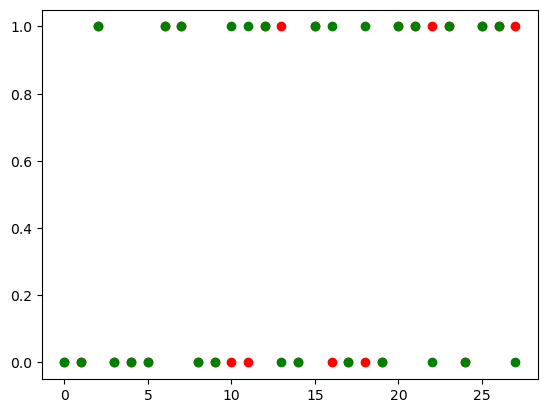

In [593]:
plt.scatter(X, pred, color="red")
plt.scatter(X, yTest, color="green")
plt.show()

In [594]:
X = df.drop(columns=["output"])
y = df["output"]

In [595]:
from sklearn.model_selection import cross_val_score

In [596]:
def crossVal(classifier, num_splits):
    scores = cross_val_score(classifier, X, y, cv = num_splits)
    print("Accuracy Scores : ", scores)
    print("Mean Accuracy Score : ", scores.mean())

In [597]:
crossVal(xgb, 5)

Accuracy Scores :  [0.64285714 0.71428571 0.60714286 0.67857143 0.71428571]
Mean Accuracy Score :  0.6714285714285715


In [598]:
params = {
    "n_estimators" : [100, 200, 300, 400, 500],
    "max_depth" : [5, 4, 3, 2, 1],
    "learning_rate" : [0.01, 0.02, 0.03, 0.05, 0.07, 0.09, 0.1, 0.2],
    "num_parallel_tree" : [3, 4, 5, 6, 7],
    "reg_alpha" : [0.5, 0.6, 0.8, 1.2, 1.3, 1.5, 1.6, 1.7],
    "reg_lambda" : [0.5, 0.7, 0.9, 1, 1.2, 1.3, 1.4]
}

In [599]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [600]:
gridXGB = RandomizedSearchCV(xgb, params,n_iter=100 ,cv=5, n_jobs=-1, scoring="f1")
gridXGB.fit(xTrain, yTrain)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                           num_parallel_tree=None,
                                           objective='binary:hinge',
                                           predictor=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.02, 0.03,
                                                          0.05, 0.07, 0.09, 0.1,
                                                          0.2],
                                        'max_depth': [5, 4, 3, 2, 1],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'num_parallel_tree': [3, 4, 5, 6, 7],
                                        'reg_alpha': [0.5, 0.6, 0.8, 1.2, 1.3,
                                                      1.5, 1.6, 1.7],
                                        'reg_lambda': [0.5, 0.7, 0.9, 1, 1.2,
                                                       1.3, 1.4]},
                   scoring='f1')

In [601]:
bestParams = gridXGB.best_params_
bestParams

{'reg_lambda': 1.3,
 'reg_alpha': 1.2,
 'num_parallel_tree': 5,
 'n_estimators': 500,
 'max_depth': 1,
 'learning_rate': 0.01}

In [602]:
bestModel = gridXGB.best_estimator_
bestModel

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=5,
              objective='binary:hinge', predictor=None, ...)

In [603]:
yPred = bestModel.predict(xTest)

In [604]:
print(accuracy_score(yPred, yTest))

0.7857142857142857


In [605]:
crossVal(bestModel, 3)

Accuracy Scores :  [0.70212766 0.78723404 0.80434783]
Mean Accuracy Score :  0.7645698427382054


In [608]:
cm = confusion_matrix(yPred, yTest)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
totalP = TP+FP
totalN = TN+FN
total = totalN + totalP

acc = (TP+TN)/(totalN+totalP)
acc*=100

print("Total : ", total, "\n")
print("True +ve :  ", TP, "     ", "{:.2f}".format((TP/totalP)*100), "%")
print("True -ve :  ", TN, "     " ,"{:.2f}".format((TN/totalN)*100), "%")
print("False +ve : ", FP, "      ", "{:.2f}".format((FP/totalP)*100), "%")
print("False -ve   ", FN, "      ", "{:.2f}".format((FN/totalN)*100), "%")
print("\n")
print("Accuracy :  ", "{:.2f}".format(acc), "%")



Total :  28 

True +ve :   11       78.57 %
True -ve :   11       78.57 %
False +ve :  3        21.43 %
False -ve    3        21.43 %


Accuracy :   78.57 %


In [609]:
bestModel.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=5,
              objective='binary:hinge', predictor=None, ...)

In [610]:
crossVal(bestModel, 3)

Accuracy Scores :  [0.70212766 0.78723404 0.80434783]
Mean Accuracy Score :  0.7645698427382054


In [611]:
bestModel.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=5,
              objective='binary:hinge', predictor=None, ...)>

In [612]:
bestCLF = XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=3,
              objective='binary:hinge')

In [613]:
bestCLF.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=3,
              objective='binary:hinge', predictor=None, ...)

In [614]:
Pred = bestCLF.predict(xTest)

In [615]:
accuracy_score(Pred, yTest)

0.7857142857142857

In [616]:
crossVal(bestCLF, 3)

Accuracy Scores :  [0.72340426 0.80851064 0.80434783]
Mean Accuracy Score :  0.778754239901326


In [617]:
cm = confusion_matrix(Pred, yTest)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
totalP = TP+FP
totalN = TN+FN

acc = (TP+TN)/(totalN+totalP)
acc*=100

print("Total : ", total, "\n")
print("True +ve :  ", TP, "     ", "{:.2f}".format((TP/totalP)*100), "%")
print("True -ve :  ", TN, "     " ,"{:.2f}".format((TN/totalN)*100), "%")
print("False +ve : ", FP, "      ", "{:.2f}".format((FP/totalP)*100), "%")
print("False -ve   ", FN, "      ", "{:.2f}".format((FN/totalN)*100), "%")
print("\n")
print("Accuracy :  ", "{:.2f}".format(acc), "%")



Total :  28 

True +ve :   11       78.57 %
True -ve :   11       78.57 %
False +ve :  3        21.43 %
False -ve    3        21.43 %


Accuracy :   78.57 %


In [221]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset'

In [222]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Models')

In [224]:
bestCLF.save_model("InvoiceDateXGBoost.json")

In [225]:
model = XGBClassifier()

In [226]:
model.load_model("InvoiceDateXGBoost.json")

In [228]:
pred = model.predict(xTest)
pred

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1])

In [229]:
yTest

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1])

In [232]:
accuracy_score(pred, yTest)

1.0